# Agent Based Hydrology Simulation

---

## 1. Introduction

---

This project examines how well Reinforcement Learning (RL) algorithms can optimize a Constant Elasticity of Substitution
(CES) production function within an Agent Based Model (ABM). A CES production function is an economic production function that essentially maps from inputs
to output where there is some substitutability between inputs<sup>1</sup>. In this simulation, the inputs are land and water, while the output is the crop yield.

With this goal as the basis of the simulation, we can break down the agent based model into the following components.

Reinforcement Learning Agent
1. Learning algorithm
2. Action-value function

Environment Model
1. Hydrology function
2. Production/reward function

## 2. Method

---

### Reinforcement Learning Agent

The reinforcement learning agent has two primary components. The first component of this is the learning algorithm. This algorithm controls how the agent explores and learns from the simulation environment. I chose Deep-Q learning<sup>2</sup> which explores the environment and collecting memory tuples:
$ (State_t, Action_t, Reward_t, State_{t+1}, Action_{t+1}) $ These memories are used to optimize the other component of
the RL agent called the action-value function. The action-value function maps from the observed state of the environment to the value of each action. The action-value function is optimized by minimizing the difference between the estimated value, and actual value of that state which is bootstrapped actual reward and estimated value of the next state. The memories are sampled with a probability proportional to this error so that the agent focuses on values it estimated poorly.<sup>3</sup>

In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LEARNING_RATE = 1e-4
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 50
UPDATE_EVERY = 4
GAMMA = 0.99
BETA = 0.0
TAU = 1e-3


class Agent:
    """Deep-Q Agent with prioritized replay buffer"""

    def __init__(self, state_size, action_size, seed):

        """
        Initializes Agent.
        """
        self.action_size = action_size

        # Q-Network
        self.qnetwork_local = Actor(state_size, action_size, seed).to(device)
        self.qnetwork_target = Actor(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LEARNING_RATE)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

        # epsilon decay
        self.eps = 1.0
        self.eps_end = 0.1
        self.eps_decay = 0.995

    def step(self, state, action, reward, next_state, done):
        """
        Saves experience in the replay buffer and decides if the network needs to be updated.

        Args:
            state: (tuple) state vector
            action: (tuple) action vector
            reward: (float) reward scalar
            next_state: (tuple) next state vector
            done: (bool) defines if state is terminal
        """
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.1):

        """
        Chooses an action with epsilon greedy policy.

        Args:
            state: (tuple) state vector
            eps: (float) epsilon value

        Returns:
            int: action index
        """
        max_yearly_water = state[1]
        max_land = state[2]
        state = torch.from_numpy(state).float().to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        water_values = action_values[0].cpu().data.numpy()
        land_values = action_values[1].cpu().data.numpy()

        water_action = np.argmax(water_values) / 100
        land_action = np.argmax(land_values) / 100

        max_water_land = np.array((max_yearly_water, max_land))

        self.eps = max(self.eps_end, self.eps * self.eps_decay)
        # Epsilon-greedy action selection
        if random.random() > self.eps:
            return np.array(water_action, land_action) * max_water_land
        else:
            return np.random.randint(0, 101, 2) / 100 * max_water_land

    def learn(self, experiences, gamma):
        # type: (tuple, float) -> None
        """
        Up date the model weights and the resulting priorities in the replay buffer.

        Args:
            experiences: (tuple) tuple of np.vstacks, data for supervised learning
            gamma: (float) expected future reward discount factor
        """
        states, actions, rewards, next_states, dones, probabilities = experiences

        sampling_weight = (1/BUFFER_SIZE * 1/probabilities) ** BETA / probabilities.squeeze().max(0)[0]

        # get action value for the chosen action
        Q_target_undiscounted = self.qnetwork_target(next_states).detach().max(2)[0].unsqueeze(2)

        # then sum the value of the water and land heads
        Q_target_undiscounted = torch.sum(Q_target_undiscounted, dim=0)

        Q_target = rewards + (gamma * Q_target_undiscounted * (1 - dones))

        Q_estimate = self.qnetwork_local(states).max(2)[0].unsqueeze(2)
        Q_estimate = torch.sum(Q_estimate, dim=0)

        loss = F.mse_loss(sampling_weight * Q_estimate, sampling_weight * Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

        # update the probabilities with new td_errors
        td_error = Q_target - Q_estimate
        self.memory.update(states, actions, rewards, next_states, dones, td_error)

    def soft_update(self, local_model, target_model, tau):
        # type: (torch.nn.Module, torch.nn.Module, float) -> None
        """
        Weighted update of local model parameters.

        θ_target = tau*θ_local + (1 - tau)*θ_target

        Args:
            local_model: (torch.nn.Module) weights will be copied from
            target_model: (torch.nn.Module) weights will be copied to
            tau: (float) interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)



class ReplayBuffer:
    """Fixed-size prioritized buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, eta=1e-5, prob_temp=0.5, temp_decay=1e-5):
        # type: (int, int, int, int, float, float, float) -> None
        """
        Initialize a ReplayBuffer object.

        Args:
            action_size: (int) dimension of each action
            buffer_size: (int) maximum size of buffer
            batch_size: (int) size of each training batch
            seed: (int) random seed
        """
        self.action_size = action_size
        self.batch_size = batch_size
        self.seed = np.random.seed(seed)
        self.eta = eta
        self.prob_temp = prob_temp
        self.temp_decay = temp_decay
        self.indexes = np.zeros(batch_size)

        self.memory = deque(maxlen=buffer_size)
        self.priority_memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience",
                                     field_names=["state", "action", "reward", "next_state", "done", "priority"])

    def add(self, state, action, reward, next_state, done):
        # type: (tuple, int, float, tuple, bool) -> None
        """
        Compute priority and add new experience to replay buffer.

        Args:
            state: (tuple) state vector
            action: (int) action index
            reward: (float) reward scalar
            next_state: (tuple) next state vector
            dones: (bool) indicates if state is terminal
            td_error: (float) used to update priority in buffer
        """

        priority = max(self.priority_memory) if len(self.memory) > 0 else 0.1
        e = self.experience(state, action, reward, next_state, done, priority)
        self.memory.append(e)
        self.priority_memory.append(priority)

    def sample(self):
        """
        Select experiences with priority probability.

        Returns:
            states: (torch.tensor) sample state tensor
            actions: (torch.tensor) sample actions tensor
            rewards: (torch.tensor) sample rewards tensor
            next_states: (torch.tensor) sample next state tensor
            dones: (torch.tensor) sample dones tensor
            priority_prob: (torch.tensor) sample priority tensor
        """

        self.prob_temp = max(0, (self.prob_temp - self.temp_decay))
        priority_array = np.array(self.priority_memory)

        priority_probability = (priority_array ** self.prob_temp) / np.sum(priority_array ** self.prob_temp)
        self.indexes = np.random.choice(np.arange(0, len(self.memory)), size=self.batch_size, replace=False, p=priority_probability)

        experiences = [self.memory[i] for i in self.indexes]
        filtered_probabilities = priority_probability[self.indexes]

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        priority_prob = torch.from_numpy(np.vstack([p for p in filtered_probabilities if p is not None])).float().to(device)

        return states, actions, rewards, next_states, dones, priority_prob

    def update(self, state, action, reward, next_state, dones, td_error):
        # type: (torch.tensor, torch.tensor, torch.tensor, torch.tensor, torch.tensor, torch.tensor, float) -> None
        """Use TD errors to change values for respective tuples in replay buffer

        Args:
            state: (torch.tensor) state vector
            action: (torch.tensor) action index
            reward: (torch.tensor) reward scalar
            next_state: (torch.tensor) next state vector
            dones: (torch.tensor) indicates if state is terminal
            td_error: (float) used to update priority in buffer
        """
        priority = (torch.abs(reward + td_error) + self.eta)

        for i, index in enumerate(self.indexes):
            self.memory[index] = self.experience(state[i].cpu().numpy(),
                                                 action[i].cpu().numpy(),
                                                 reward[i].cpu().numpy(),
                                                 next_state[i].cpu().numpy(),
                                                 dones[i].cpu().numpy(),
                                                 priority[i].cpu().item(),
                                                 )
            self.priority_memory[index] = priority[i].item()

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Actor(nn.Module):
    """Actor, Action-Value function."""

    def __init__(self, state_size, action_size, seed, fc_units=256):
        """
        Initialize parameters and build model.

        Args:
            state_size (int): Dimension of state space
            action_size (int): Dimension of action space
            seed (int): Random seed
            fc_units (int): Hidden layer dimension
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed) if seed is not None else None

        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc_units)

        self.fc_water_head_1 = nn.Linear(fc_units, fc_units)
        self.fc_water_head_2 = nn.Linear(fc_units, action_size)

        self.fc_land_head_1 = nn.Linear(fc_units, fc_units)
        self.fc_land_head_2 = nn.Linear(fc_units, action_size)

        self.dropout_1 = nn.Dropout(p=0.25)
        self.dropout_2 = nn.Dropout(p=0.25)
        self.dropout_3 = nn.Dropout(p=0.25)
        self.dropout_4 = nn.Dropout(p=0.25)

        self.reset_parameters()

    def reset_parameters(self):
        """
        Initializes network weights using uniform distribution rather than Gaussian.
        """
        self.fc1.weight.data.uniform_(-3e-3, 3e-3)
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

        self.fc_water_head_1.weight.data.uniform_(-3e-3, 3e-3)
        self.fc_water_head_2.weight.data.uniform_(-3e-3, 3e-3)

        self.fc_land_head_1.weight.data.uniform_(-3e-3, 3e-3)
        self.fc_land_head_2.weight.data.uniform_(-3e-3, 3e-3)


    def forward(self, state):
        """
        Maps states -> action values

        Args:
            state vector (torch.tensor):
            [batch, available_water, max_water, available_land, crop_price]
        """

        x1 = self.dropout_1(F.relu(self.fc1(state)))
        x2 = self.dropout_2(F.relu(self.fc2(x1)))

        x_water = self.dropout_3(F.relu(self.fc_water_head_1(x2)))
        x_land = self.dropout_4(F.relu(self.fc_land_head_1(x2)))

        water_values = self.fc_water_head_2(x_water)
        land_values = self.fc_land_head_2(x_land)

        return torch.stack((water_values, land_values))

## Environmental Model

The environmental model is comprised of a hydrology function and a reward function. The hydrology function is simple. There is a river continuum with agents placed on it linearly. When an upstream agent removes water from the river, downstream water is reduced by that amount. The reward function is primarily comprised of the CES function which takes this general form:

$$ Q_i = \pi_i (\beta_{land} * x^\rho_{land} + \beta_{water} * x^\rho_{water})^{r/\rho} $$

$$ \beta_{land} + \beta_{water} = 1 $$

$ Q_i =$ quantity of output, pounds of crop $i$

$\pi_i = $ factor productivity, normalizes units, from real-world data

$\beta = $ share parameter, measures how important each input is, from real-world data

$\rho = $ substitution parameter, how willing is the agent to swap $x_{land}$ for $x_{water}$, from real world data

$r = $ returns to scale, does crop $ i $ have economies of scale, from real-world data

$ x_{input} = $ quantity of given input, agents action space


In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
class SimConfig:
    """
    This config class simplifies the initialization of the SimulationCES class.
    """

    def __init__(self):
        # general simulation parameters
        self.num_years = 2000

        # crop parameters
        self.num_crops = 1
        self.crop_1_price = 10
        self.crop_1 = {"pi": 10,
                       "beta_land": 0.5,
                       "beta_water": 0.5,
                       "rho": 1,
                       "r": 1}

        # hydrology function, current estimate based on lower Clark Fork
        self.water_mu = 0.75e6  # cfs
        self.water_sigma = 1e2  # cfs

        # stochastic water dist
        self.water_dist = self.water_sigma * np.random.randn(100) + self.water_mu
        # # constant water dist
        # self.water_dist = np.full(100, self.water_mu)

        # simulation parameters
        self.number_farmers = 3
        self.farmer_priority = [0, 1, 2]
        # self.random_seed = 1    # seems like decent seed
        self.random_seed = None

        # agent parameters
        self.state_size = 4
        self.action_size = 101      # percentage of resource used, need 101 to accommodate 0-100 range
        self.memory_size = 10

        # land and water physical constraints
        # land available to each farmer
        self.available_land = [100 for _ in range(self.number_farmers)]

        # max water for each farmer, physical equipment constraint
        self.max_yearly_water = [1.5e6 for _ in range(self.number_farmers)]

        # experimental parameters
        self.epsilon_test = False

In [6]:

class SimulationCES:
    """
    Simulation environment utilizing CES production function
    """

    def __init__(self, config: SimConfig):
        # simulation configuration
        self.config = config

        # simulation records for analysis
        self.farmers_rewards_record = [[] for _ in range(config.number_farmers)]
        self.water_record = {"Surface": []}
        self.farmers_water_withdrawal_record = [[] for _ in range(config.number_farmers)]
        self.farmers_actions_record = [[] for _ in range(config.number_farmers)]
        self.farmer_available_water_record = [[] for _ in range(config.number_farmers)]

        # simulation parameters
        self.num_farmers = config.number_farmers
        self.farmer_priority = config.farmer_priority
        self.farmer_list = [Agent(config.state_size, config.action_size, config.random_seed) for _ in
                            range(self.num_farmers)]

        # simulation state parameters
        self.year = 1
        self.num_years = config.num_years

        # simulation functions, reward function is a property
        self.hydrology_function = config.water_dist

        # initialize river continuum
        self.source_water = self.init_available_water()
        self.available_water = [self.source_water for _ in range(self.num_farmers)]

        # land available to each farmer
        self.available_land = config.available_land

        # max water for each farmer, physical equipment constraint
        self.max_yearly_water = config.max_yearly_water

        # production function parameters
        self.crop_1 = config.crop_1
        self.crop_1_price = config.crop_1_price

        # experimental parameters
        self.epsilon_test = config.epsilon_test

        # plot data
        self.reward_plot_data = None

    def reset(self):
        """
        Resets the simulation environment. Open AI Gym interface.

        Only the river continuum needs to be reset each episode.
        Everything else needs to persist between episodes. I think...

        Returns: None
        """

        # re-initialize available water, this includes surface
        self.source_water = self.init_available_water()
        self.available_water = [self.source_water for _ in range(self.num_farmers)]

        return None

    def reward_function(self, action):

        x1_water, x1_land = action

        """input amounts are the action space for the agents"""
        q_1 = self.crop_1["pi"] * (
                self.crop_1["beta_land"] * (x1_land ** self.crop_1["rho"]) + self.crop_1["beta_water"] * (
                x1_water ** self.crop_1["rho"])) ** (self.crop_1["r"] / self.crop_1["rho"])

        # calc rewards
        r_1 = np.log(q_1 * self.crop_1_price + 1e-3)

        land_cost = self.land_cost_function(x1_land)
        water_cost = self.water_cost_function(x1_water)
        total_cost = land_cost + water_cost

        shadow_price = 0

        return r_1 - total_cost - shadow_price

    def water_cost_function(self, total_water):
        """
        Linear cost for water.
        :param total_water: total water used for the farmer.
        :return: total water cost
        """
        w_0 = 3e-6
        cost = w_0 * total_water

        return cost

    def land_cost_function(self, total_land):
        """
        Linear Cost for Land
        :param total_land: total land used by the farmer.
        :return: total land cost
        """
        w_0 = 3e-6

        cost = w_0 * total_land

        return cost

    def evaluate_reward(self):
        x_len = int(1.2e6)
        water = np.arange(x_len) + 1
        land = np.full(x_len, 100)

        # combine water and land
        action_vec = np.stack((water, land), axis=-1)

        y = []
        for action in action_vec:
            y.append(self.reward_function(action))

        x = action_vec[:, 0]

        self.reward_plot_data = (x, y)

    def plot_reward(self):
        if self.reward_plot_data is not None:
            x, y = self.reward_plot_data
            plt.title("Reward Function")
            plt.xlabel("Water")
            plt.ylabel("Reward")
            plt.plot(x, y)
            plt.show()

        else:
            print("No data. Run self.evaluate_reward()")

        return None

    def plot_summary(self):

        if self.reward_plot_data is None:
            self.evaluate_reward()

        avg_reward = []
        for record in self.farmers_rewards_record:
            avg_reward.append(np.convolve(record, np.ones(100), 'valid') / 100)

        avg_water_withdrawn = []
        for record in self.farmers_water_withdrawal_record:
            avg_water_withdrawn.append(np.convolve(record, np.ones(100), 'valid') / 100)

        avg_water_available = []
        for record in self.farmer_available_water_record:
            avg_water_available.append(np.convolve(record, np.ones(100), 'valid') / 100)

        x = np.arange(len(avg_reward[0]))

        fig = plt.figure(figsize=(20,10))
        gs = fig.add_gridspec(2,2, wspace=0.25, hspace=0.25)
        axs = gs.subplots()

        optimum_reward = np.max(self.reward_plot_data[1])
        axs[0][0].set(xlabel="Iteration", ylabel="Reward")
        axs[0][0].plot(x, avg_reward[0],'b-', label="Farmer 1")
        axs[0][0].plot(x, avg_reward[1], 'r-', label="Farmer 2")
        axs[0][0].plot(x, avg_reward[2], 'g-', label="Farmer 3")
        axs[0][0].plot(x, np.full(x.shape, optimum_reward), 'c-', label="Optimum")
        axs[0][0].legend()

        optimum_water = np.argmax(self.reward_plot_data[1])
        axs[0][1].set(xlabel="Iteration", ylabel="Water Withdrawn")
        axs[0][1].plot(x, avg_water_withdrawn[0], 'b-', label="Farmer 1")
        axs[0][1].plot(x, avg_water_withdrawn[1], 'r-', label="Farmer 2")
        axs[0][1].plot(x, avg_water_withdrawn[2], 'g-', label="Farmer 3")
        axs[0][1].plot(x, np.full(x.shape, optimum_water), 'c-', label="Optimum")
        axs[0][1].legend()

        axs[1][0].set(xlabel="Iteration", ylabel="Available Water")
        axs[1][0].plot(x, avg_water_available[0], 'b-', label="Farmer 1")
        axs[1][0].plot(x, avg_water_available[1], 'r-', label="Farmer 2")
        axs[1][0].plot(x, avg_water_available[2], 'g-', label="Farmer 3")
        axs[1][0].legend()

        axs[1][1].set(xlabel="Water", ylabel="Reward")
        axs[1][1].plot(self.reward_plot_data[0], self.reward_plot_data[1])
        axs[1][1].plot(avg_water_withdrawn[0][-1], avg_reward[0][-1], 'bo', label="Farmer 1")
        axs[1][1].plot(avg_water_withdrawn[1][-1], avg_reward[1][-1], 'ro', label="Farmer 2")
        axs[1][1].plot(avg_water_withdrawn[2][-1], avg_reward[2][-1], 'go', label="Farmer 3")
        axs[1][1].legend()

        print("100 Iteration Moving Average")
        plt.show()

        return None

    def init_available_water(self):
        """
        Initializes available water for beginning of episode.
        Pulls random sample from historic discharge distribution.

        This needs to be a function call so that we get a new random number each time we want to initialize
        a seasons available water.

        Returns: (float) available water.
        """
        # get initial values for water types
        surface_water = np.random.choice(self.hydrology_function)

        # update water records
        self.water_record["Surface"].append(surface_water)

        return surface_water

    def update_available_water(self, priority_index, action):
        """
        Updates all available water down stream from agent indicated by priority index.

        Args:
            priority_index: indicates at what point in the river continuum to update flows
            action: amount of water removed by agent
        """
        # determine the total water removed
        total_removed = action[0]
        self.farmers_water_withdrawal_record[priority_index].append(total_removed)

        # determine how much water needs to come from surface water
        surface_removed = total_removed

        # remove water from surface continuum, max operation prevents negative water amounts
        for i in range(priority_index, len(self.available_water)):
            self.available_water[i] = max(self.available_water[i] - surface_removed, 1e-3)

        return None

    def step(self):
        """
        Takes a step in the environment and updates all relevant instance attributes.

        This will look a little different than most other RL training loops for two reasons:
        1. This is inherently a multi agent system
        2. There is only one step in each episode

        Returns: None
        """

        # iterate through farmers in their priority order
        for priority_num in self.farmer_priority:
            agent = self.farmer_list[priority_num]

            # epsilon test
            if self.epsilon_test and 1100 > self.year > 1000:
                agent.eps = 0.75

            state = np.concatenate((
                [self.available_water[priority_num]],
                [min(self.max_yearly_water[priority_num], self.available_water[priority_num])],
                [self.available_land[priority_num]],
                [self.crop_1_price])
            )

            # record available water for this farmer
            self.farmer_available_water_record[priority_num].append(self.available_water[priority_num])

            # get action, and record actions for debugging
            action = agent.act(state)
            self.farmers_actions_record[priority_num].append(action)

            reward = self.reward_function(action)
            self.update_available_water(priority_num, action)

            # save reward for later analysis
            self.farmers_rewards_record[priority_num].append(reward)

            # estimate next action and save state information in agent memory
            next_state = np.concatenate((
                [self.available_water[priority_num]],
                [min(self.max_yearly_water[priority_num], self.available_water[priority_num])],
                [self.available_land[priority_num]],
                [self.crop_1_price])
            )
            agent.step(state, action, reward, next_state, True)

        # 1 year of simulation complete, reset the source water
        self.reset()
        self.year += 1

#
# for debugging
# config = SimConfig()
# config.farmer_priority = [0, 1, 2]
# env = SimulationCES(config)
#
# for i_episode in range(1, env.num_years + 1):
#     env.step()
# env.plot_summary()

I am interested in how well the RL agents optimize this reward function:

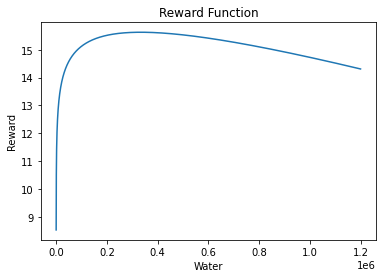

In [7]:
config = SimConfig()
env = SimulationCES(config)

env.evaluate_reward()
env.plot_reward()

It initially appears that agents find solutions around the optimum.

100 Iteration Moving Average


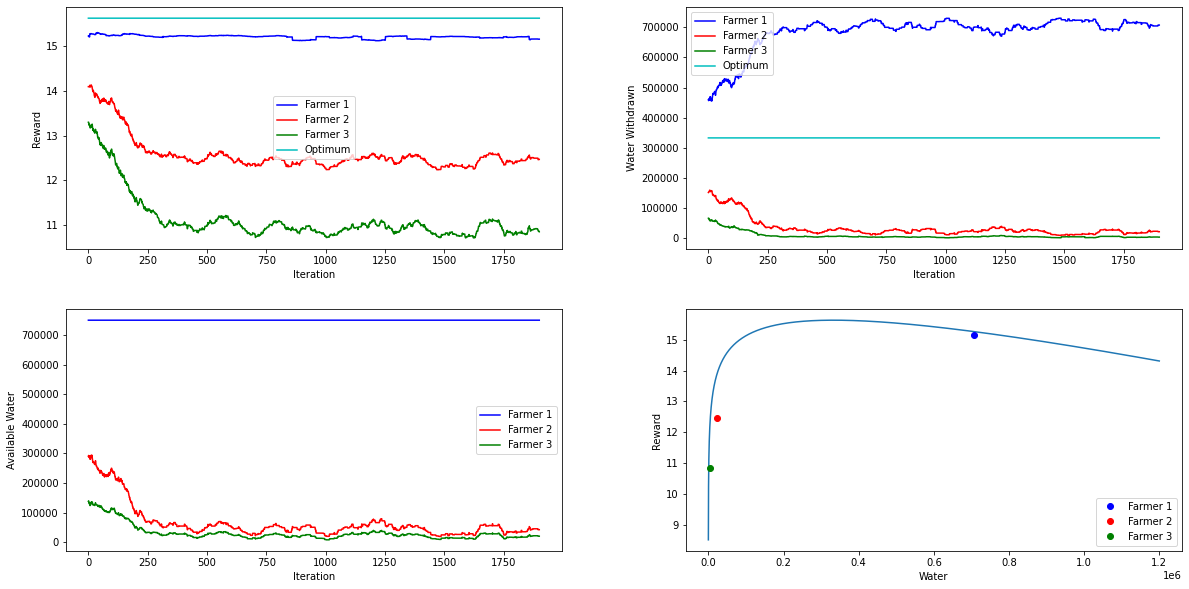

In [8]:
for i_episode in range(1, env.num_years + 1):
    env.step()
env.plot_summary()

## 3. Analysis Questions

1. What is the distribution around these optimum with different initializations of action-value function parameters.

2. Does changing the RL agent's exploration parameter, epsilon, change the steady state solution?

---

### Question 1

Each time an agent is initialized, the neural network that estimates the action-value function is initialized with different weights.
To determine how different weight initializations affect the steady state solution, I will initialize a population of agents
subject to the same environmental conditions and examine the distribution of solutions.

In [9]:
config = SimConfig()
config.num_years = 1000

population = 5
rewards = []
water_withdrawn = []

env = SimulationCES(config)
env.evaluate_reward()
optimum_reward = np.max(env.reward_plot_data[1])
optimum_water = np.argmax(env.reward_plot_data[1])

for _ in range(population):
    env = SimulationCES(config)

    for i_episode in range(1, env.num_years + 1):
        env.step()

    rewards.append(env.farmers_rewards_record[0])
    water_withdrawn.append((env.farmers_water_withdrawal_record[0]))


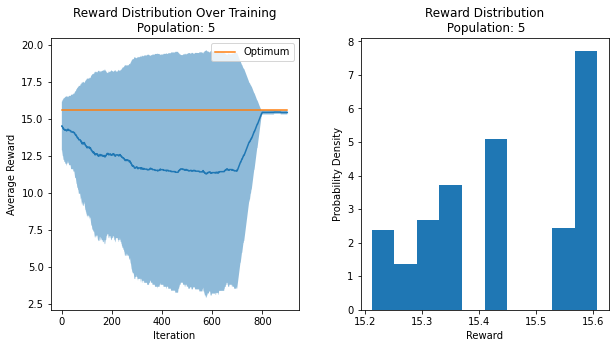

In [10]:
moving_avg_reward = []
for record in rewards:
    moving_avg_reward.append(np.convolve(record, np.ones(100), 'valid') / 100)

moving_avg_reward = np.array(moving_avg_reward)
reward_mean = np.mean(moving_avg_reward, axis=0)
reward_std = np.std(moving_avg_reward, axis=0)

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1,2, wspace=0.25, hspace=0.25)
axs = gs.subplots()

x = np.arange(len(reward_std))
axs[0].set(title=f"Reward Distribution Over Training\n Population: {len(moving_avg_reward)}",
           xlabel="Iteration",
           ylabel="Average Reward")
axs[0].plot(x, reward_mean)
axs[0].plot(x, np.full(x.shape, optimum_reward), label="Optimum")
axs[0].fill_between(x, reward_mean - reward_std, reward_mean + reward_std, alpha=0.5)
axs[0].legend()

solution_dist = moving_avg_reward[:, -100:].flatten()
axs[1].set(title=f"Reward Distribution\n Population: {len(moving_avg_reward)}",
           xlabel="Reward",
           ylabel="Probability Density")
plt.hist(solution_dist, density=True, bins=10)

plt.show()

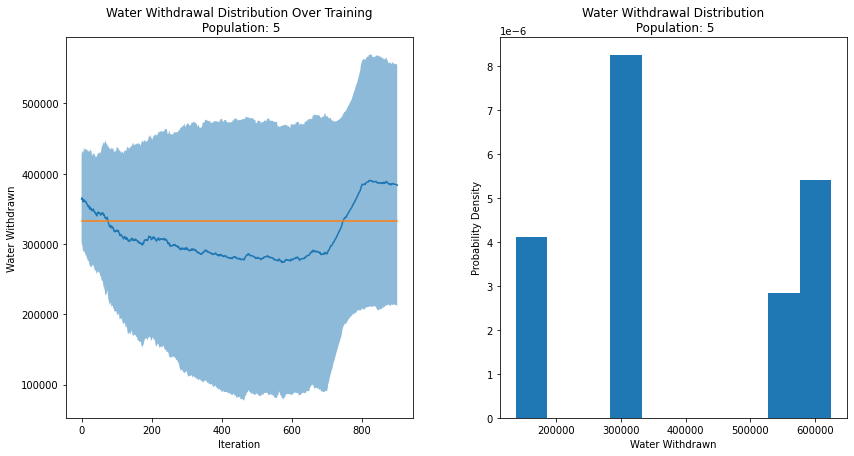

In [11]:
moving_avg_water = []
for record in water_withdrawn:
    moving_avg_water.append(np.convolve(record, np.ones(100), 'valid') / 100)

moving_avg_water = np.array(moving_avg_water)
water_mean = np.mean(moving_avg_water, axis=0)
water_std = np.std(moving_avg_water, axis=0)

fig = plt.figure(figsize=(14,7))
gs = fig.add_gridspec(1,2, wspace=0.25, hspace=0.25)
axs = gs.subplots()

x = np.arange(len(water_std))
axs[0].set(title=f"Water Withdrawal Distribution Over Training\n Population: {len(moving_avg_water)}",
           xlabel="Iteration",
           ylabel="Water Withdrawn")
axs[0].plot(x, water_mean)
axs[0].plot(x, np.full(x.shape, optimum_water), label="Optimum")
axs[0].fill_between(x, water_mean - water_std, water_mean + water_std, alpha=0.5)

solution_dist = moving_avg_water[:, -100:].flatten()
axs[1].set(title=f"Water Withdrawal Distribution\n Population: {len(moving_avg_water)}",
           xlabel="Water Withdrawn",
           ylabel="Probability Density")
plt.hist(solution_dist, density=True, bins=10)

plt.show()

The error range is +/- 1 standard deviation from the mean. It appears that the stable solutions are multimodal.
The mean reward is lower than the optimum but still within one standard deviations of the mean solution.
This suggests that weight initialization determines the agent stabilizes in the solution space. It is also interesting
to note that the spread of the solutions increases as the iteration increases. This further suggests that the weight initialization
determines the stable solution for the agent.

In [12]:
config = SimConfig()
config.num_years = 1000

population = 50
rewards = []
water_withdrawn = []

env = SimulationCES(config)
env.evaluate_reward()
optimum_reward = np.max(env.reward_plot_data[1])
optimum_water = np.argmax(env.reward_plot_data[1])

for _ in range(population):
    env = SimulationCES(config)

    for i_episode in range(1, env.num_years + 1):
        env.step()

    rewards.append(env.farmers_rewards_record[0])
    water_withdrawn.append((env.farmers_water_withdrawal_record[0]))


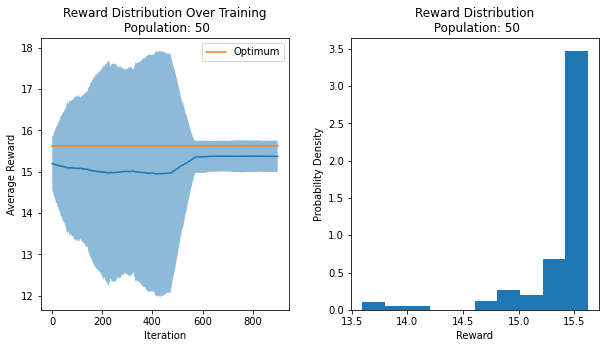

In [13]:
moving_avg_reward = []
for record in rewards:
    moving_avg_reward.append(np.convolve(record, np.ones(100), 'valid') / 100)

moving_avg_reward = np.array(moving_avg_reward)
reward_mean = np.mean(moving_avg_reward, axis=0)
reward_std = np.std(moving_avg_reward, axis=0)

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1,2, wspace=0.25, hspace=0.25)
axs = gs.subplots()

x = np.arange(len(reward_std))
axs[0].set(title=f"Reward Distribution Over Training\n Population: {len(moving_avg_reward)}",
           xlabel="Iteration",
           ylabel="Average Reward")
axs[0].plot(x, reward_mean)
axs[0].plot(x, np.full(x.shape, optimum_reward), label="Optimum")
axs[0].fill_between(x, reward_mean - reward_std, reward_mean + reward_std, alpha=0.5)
axs[0].legend()

solution_dist = moving_avg_reward[:, -100:].flatten()
axs[1].set(title=f"Reward Distribution\n Population: {len(moving_avg_reward)}",
           xlabel="Reward",
           ylabel="Probability Density")
plt.hist(solution_dist, density=True, bins=10)

plt.show()

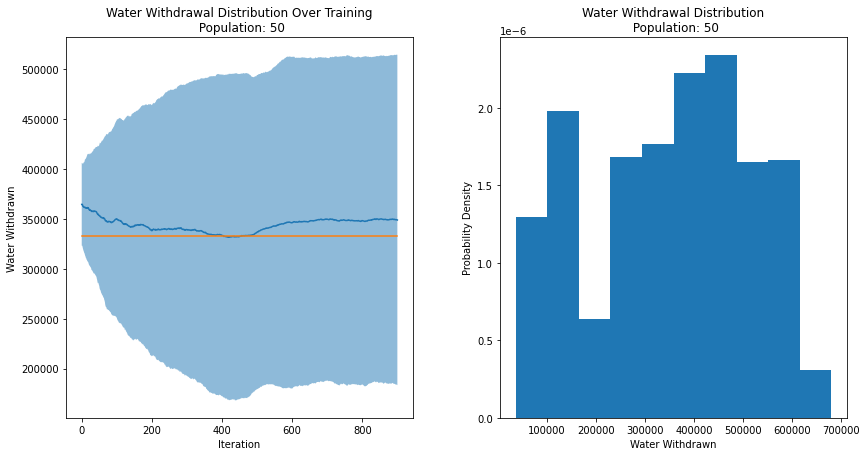

In [14]:
moving_avg_water = []
for record in water_withdrawn:
    moving_avg_water.append(np.convolve(record, np.ones(100), 'valid') / 100)

moving_avg_water = np.array(moving_avg_water)
water_mean = np.mean(moving_avg_water, axis=0)
water_std = np.std(moving_avg_water, axis=0)

fig = plt.figure(figsize=(14,7))
gs = fig.add_gridspec(1,2, wspace=0.25, hspace=0.25)
axs = gs.subplots()

x = np.arange(len(water_std))
axs[0].set(title=f"Water Withdrawal Distribution Over Training\n Population: {len(moving_avg_water)}",
           xlabel="Iteration",
           ylabel="Water Withdrawn")
axs[0].plot(x, water_mean)
axs[0].plot(x, np.full(x.shape, optimum_water), label="Optimum")
axs[0].fill_between(x, water_mean - water_std, water_mean + water_std, alpha=0.5)

solution_dist = moving_avg_water[:, -100:].flatten()
axs[1].set(title=f"Water Withdrawal Distribution\n Population: {len(moving_avg_water)}",
           xlabel="Water Withdrawn",
           ylabel="Probability Density")
plt.hist(solution_dist, density=True, bins=10)

plt.show()

Notice that as the population increases, the solution distributions get better behaved, and the solution gets closer to the optimum.



### Question 2
To examine the second question, I will train an agent for a number of iteration then reset the exploration parameter.
This should fill the experience memory buffer with new experiences to train its action-value function with. It makes sense
that if the agent finds the optimum solution in this exploration that it should change its behavior to that optimum.
But does this happen?

100 Iteration Moving Average


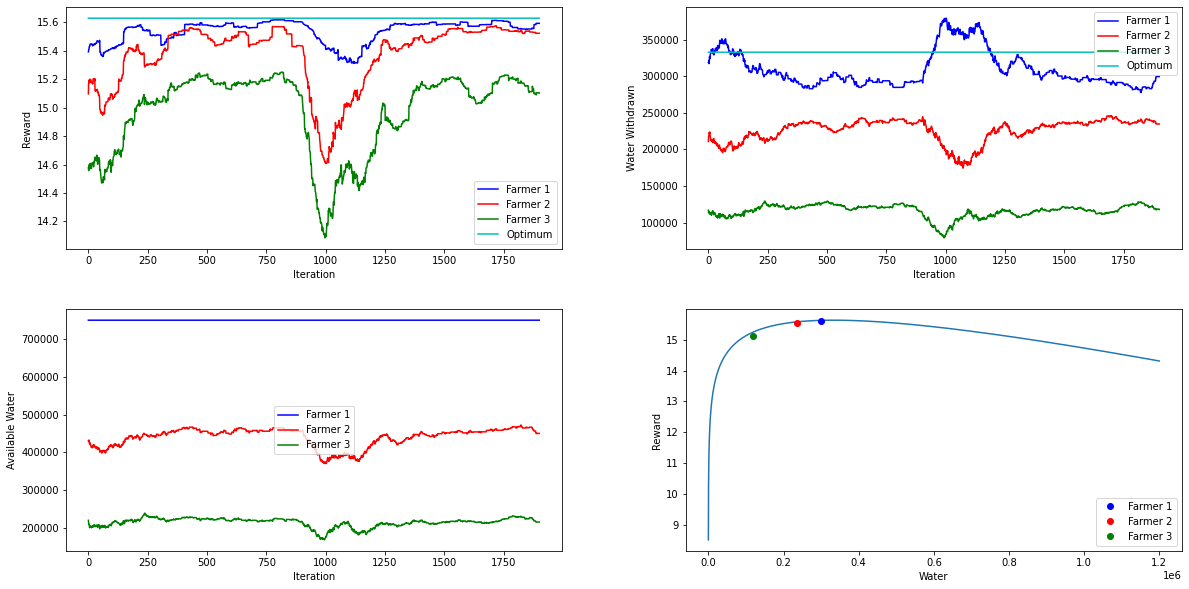

In [15]:
config = SimConfig()
config.epsilon_test = True
env = SimulationCES(config)

for i_episode in range(1, env.num_years + 1):
    env.step()
env.plot_summary()

At iteration 1000, the exploration parameter, epsilon, is reset and held for 100 iterations.
This parameter controls the probability of the agent taking a completely random action.
The normal algorithm starts with this parameter at 100% and decays it at each iteration step.
It is clear that even when the exploration parameter is reset, and the agent gets experiences that bring it closer to the optimum, the agent does not change its steady state behavior.

## 4. Interpretation

---

When we examine question 1, it is clear that the action-value parameter initialization plays a significant role in the steady state solution.
This is reinforced by the results from question 2.
Moreover, the epsilon test drove some agents towards optimum behavior, and they still return to their previous behavior.
This suggests that there are non-unique solutions to this optimization problem in network weight space as suggested in Deep Ensembles.<sup>4</sup>
As we saw in question 1, as we increase population size, the distribution of solutions gets more consistent and closer to the optimum.
Future work should focus on ways to leverage this observation with ensembles<sup>5</sup> or using multiple dropout inferences<sup>6</sup>.

The behavior seen in question two is more perplexing. Perhaps the distance in action-value parameter space is larger than the distance in soluton space.
This would make it hard to travers from one local minima to another in parameter space.
It may also have to do with the memory replay sampling.
Currently, the algorithm will prioritize sampling memories that the action-value function estimated poorly.
This means that there is an inductive bias to avoid taking bad actions as opposed to seeking good actions.
Future work should try inverting this bias by prioritizing memories that the action-value function estimated well.
Future work could also examine how decaying epsilon affects the steady state solutions.


#### References
1. Howitt, Richard E., Duncan MacEwan, Josué Medellín-Azuara, and Jay R. Lund. "Economic modeling of agriculture and water in California using the statewide agricultural production model." Davis, CA: University of California (2010).

2. Mnih, Volodymyr, Koray Kavukcuoglu, David Silver, Alex Graves, Ioannis Antonoglou, Daan Wierstra, and Martin Riedmiller. "Playing atari with deep reinforcement learning." arXiv preprint arXiv:1312.5602 (2013).

3. Schaul, Tom, John Quan, Ioannis Antonoglou, and David Silver. "Prioritized experience replay." arXiv preprint arXiv:1511.05952 (2015).

4. Fort, Stanislav, Huiyi Hu, and Balaji Lakshminarayanan. "Deep ensembles: A loss landscape perspective." arXiv preprint arXiv:1912.02757 (2019).

5. Breiman, Leo. "Bagging predictors." Machine learning 24, no. 2 (1996): 123-140.

6. Gal, Yarin, and Zoubin Ghahramani. "Dropout as a bayesian approximation: Representing model uncertainty in deep learning." In international conference on machine learning, pp. 1050-1059. PMLR, 2016.